In [6]:
# =====================[ Imports ]=====================
import os
from pathlib import Path

import pandas as pd
import numpy as np
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

import timm
import torch
import torch.nn as nn
import gc
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

from transformers import AutoTokenizer, AutoModel, BertTokenizer

In [7]:
# =====================[ Configuration ]=====================
# Set base paths for dataset
DATA_DIR = Path("fashion_dataset")
IMAGE_DIR = DATA_DIR / "images"
CSV_PATH = DATA_DIR / "styles.csv"

# Define the target label columns for multi-task learning
label_cols = ['gender', 'masterCategory', 'subCategory', 'baseColour', 'season', 'articleType']

# Load the dataset CSV file and skip any problematic lines
df = pd.read_csv(CSV_PATH, on_bad_lines='skip')

# For experimentation purposes, only use the first 3000 rows


# =====================[ Helper Function: Filter Rare Classes ]=====================
def remove_rows_with_low_value_counts(df, threshold=20, columns=None):
    """
    Remove rows that contain infrequent classes (below a certain threshold) 
    in specified categorical columns.

    Args:
        df (pd.DataFrame): Input DataFrame.
        threshold (int): Minimum number of samples required for a class to be kept.
        columns (list): List of column names to check.

    Returns:
        pd.DataFrame: Filtered DataFrame with rare classes removed.
    """
    if columns is None:
        columns = df.columns  # By default, apply to all columns (not recommended)

    initial_size = df.shape[0]  # Store the original number of rows

    # Boolean mask to keep valid rows
    mask = pd.Series(True, index=df.index)

    for col in columns:
        value_counts = df[col].value_counts()
        valid_values = value_counts[value_counts >= threshold].index
        print(f"Column '{col}': keeping {len(valid_values)} out of {len(value_counts)} classes")
        mask &= df[col].isin(valid_values)

    # Apply mask to filter the DataFrame
    df_filtered = df[mask]

    print(f"Size before filtering: {initial_size}")
    print(f"Size after filtering: {df_filtered.shape[0]}")

    return df_filtered


# Specify the columns to apply the filtering
columns_to_check = ['masterCategory', 'articleType', 'baseColour']

# Apply filtering to remove rare classes
df = remove_rows_with_low_value_counts(df, threshold=20, columns=columns_to_check)

Column 'masterCategory': keeping 6 out of 7 classes
Column 'articleType': keeping 90 out of 143 classes
Column 'baseColour': keeping 42 out of 46 classes
Size before filtering: 44424
Size after filtering: 43972


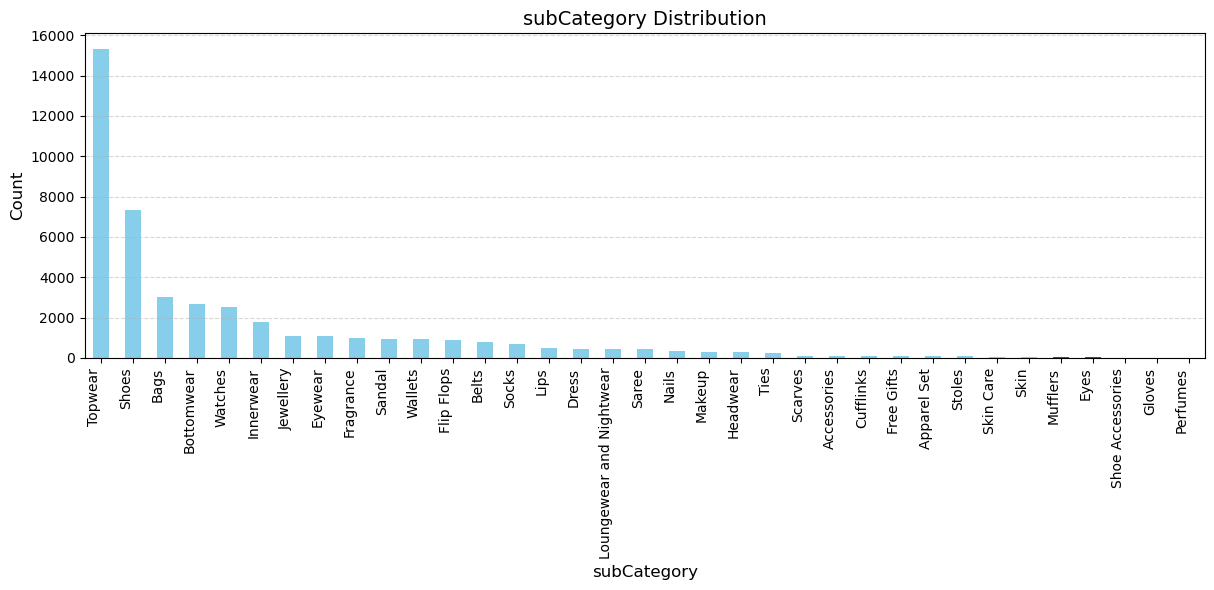

In [8]:
# =====================[ Helper Function: Plot Label Distribution ]=====================
def plot_label_distribution_adaptive(df, column, min_count=20):
    """
    Plot a bar chart showing the distribution of categories within a column.
    Bars with low sample counts are highlighted in red for clarity.

    Args:
        df (pd.DataFrame): Input DataFrame.
        column (str): The column to visualize.
        min_count (int): Threshold for highlighting low-frequency labels.
    """
    counts = df[column].value_counts().sort_values(ascending=False)
    n_labels = len(counts)

    # Automatically adjust figure width based on number of classes
    plt.figure(figsize=(max(12, n_labels * 0.35), 6))

    # Color bars red if count is below min_count
    colors = ['red' if v < min_count else 'skyblue' for v in counts]
    counts.plot(kind="bar", color=colors)

    # Chart aesthetics
    plt.title(f"{column} Distribution", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=90, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Plot label distribution for the subCategory column
plot_label_distribution_adaptive(df, "subCategory", min_count=50)

In [9]:
# =====================[ Function: Load and Preprocess Dataset ]=====================
def load_fashion_data(df):
    """
    Load and preprocess the fashion product dataset.

    Steps:
    - Drop rows with missing values in important label columns.
    - Create image filenames based on the 'id' column.
    - Keep only rows with images that exist in the image directory.
    - Combine label columns into a single 'labels' string (useful for captioning or multi-tasking).

    Args:
        df (pd.DataFrame): Raw DataFrame loaded from CSV.

    Returns:
        pd.DataFrame: Cleaned and filtered DataFrame.
    """
    # Drop samples missing any of the main label fields
    df = df.dropna(subset=['gender', 'masterCategory', 'subCategory', 'baseColour', 'season','articleType'])

    # Create a new column 'image' from the 'id' field
    df['image'] = df['id'].astype(str) + ".jpg"

    # Keep only rows where image files actually exist
    df = df[df['image'].isin(os.listdir(IMAGE_DIR))]

    # Concatenate label columns into a single string (e.g., for text-based tasks or debugging)
    df['labels'] = df[['gender', 'masterCategory', 'subCategory', 'baseColour', 'season','articleType']].agg('|'.join, axis=1)

    print(f" Dataset loaded: {len(df)} valid image records")
    return df


# =====================[ Function: Analyze Subcategory Distribution ]=====================
def analyze_subcategory(df):
    """
    Analyze the distribution of 'subCategory' values in the dataset.
    Also provides recommendations for threshold-based filtering.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.Series: Value counts of subcategories.
    """
    subcategory_counts = df['subCategory'].value_counts()

    print("\n === SUBCATEGORY ANALYSIS ===")
    print(f"Total unique subcategories: {len(subcategory_counts)}")
    print(f"Most common subcategory: '{subcategory_counts.index[0]}' ({subcategory_counts.iloc[0]} samples)")
    print(f"Least common subcategory: '{subcategory_counts.index[-1]}' ({subcategory_counts.iloc[-1]} samples)")

    print("\n Filtering Recommendations:")
    for threshold in [30, 50, 100, 200]:
        classes_to_remove = subcategory_counts[subcategory_counts < threshold]
        samples_retained = len(df) - classes_to_remove.sum()
        retention_pct = (samples_retained / len(df)) * 100
        print(f"  - Threshold {threshold}: Remove {len(classes_to_remove)} classes "
              f"→ Retain {retention_pct:.1f}% of data")

    return subcategory_counts


# =====================[ Function: Filter Dataset Based on Threshold ]=====================
def filter_data(df, subcategory_threshold=50):
    """
    Filter out subcategories that appear less than a specified threshold.

    Args:
        df (pd.DataFrame): Input DataFrame.
        subcategory_threshold (int): Minimum number of samples required for a subcategory to be kept.

    Returns:
        pd.DataFrame: Filtered dataset with rare subcategories removed.
    """
    subcategory_counts = df['subCategory'].value_counts()
    valid_subcategories = subcategory_counts[subcategory_counts >= subcategory_threshold].index

    df_filtered = df[df['subCategory'].isin(valid_subcategories)]

    print(f"""
📂 SubCategory Filtering Summary
----------------------------------
- Threshold: {subcategory_threshold}
- Original subcategories: {len(df['subCategory'].unique())}
- Subcategories kept: {len(df_filtered['subCategory'].unique())}
- Filtered dataset size: {len(df_filtered)} samples
- Retention rate: {len(df_filtered) / len(df) * 100:.1f}%
""")

    return df_filtered


# =====================[ Step-by-step Execution ]=====================

# Step 1: Load and clean dataset
df = load_fashion_data(df)

# Step 2: Analyze subcategory distribution
subcategory_counts = analyze_subcategory(df)

# Step 3: Filter dataset based on subcategory threshold
df = filter_data(df, subcategory_threshold=50)

# ➕ Now you can continue using `df` for modeling or visualization

C:\Users\Hamid\AppData\Local\Temp\ipykernel_25028\1875146605.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['id'].astype(str) + ".jpg"


 Dataset loaded: 43947 valid image records

 === SUBCATEGORY ANALYSIS ===
Total unique subcategories: 35
Most common subcategory: 'Topwear' (15324 samples)
Least common subcategory: 'Perfumes' (6 samples)

 Filtering Recommendations:
  - Threshold 30: Remove 3 classes → Retain 99.9% of data
  - Threshold 50: Remove 5 classes → Retain 99.7% of data
  - Threshold 100: Remove 9 classes → Retain 99.1% of data
  - Threshold 200: Remove 13 classes → Retain 98.1% of data

📂 SubCategory Filtering Summary
----------------------------------
- Threshold: 50
- Original subcategories: 35
- Subcategories kept: 30
- Filtered dataset size: 43830 samples
- Retention rate: 99.7%

